# 1. Imports en Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge


# hier pivot ik de tabel en laat ik alle strings weg in elke kolom.
nut = pd.read_csv('/data/foodboost/nutritions.csv')
nut_pivot= nut.pivot_table(index='recipe', columns="nutrition", values="value", aggfunc="sum")
nut_pivot['eiwit'] = nut_pivot['eiwit'].str.replace('g', '').astype(float)
nut_pivot['vet'] = nut_pivot['vet'].str.replace('g', '').astype(float)
nut_pivot['koolhydraten'] = nut_pivot['koolhydraten'].str.replace('g', '').astype(float)
nut_pivot['energie'] = nut_pivot['energie'].str.replace('kcal', '').astype(float)
nut_pivot['natrium'] = nut_pivot['natrium'].str.replace('mg', '').astype(float)
nut_pivot['vezels'] = nut_pivot['vezels'].str.replace('g', '').astype(float)
nut_pivot['waarvan suikers'] = nut_pivot['waarvan suikers'].str.replace('g', '').astype(float)
nut_pivot['waarvan verzadigd'] = nut_pivot['waarvan verzadigd'].str.replace('g', '').astype(float)

# hier replace ik alle na waardes met 0
nut_pivot= nut_pivot.fillna(0) 

# hier group ik alle tags van elke recept in een rij
tags = pd.read_csv('/data/foodboost/tags.csv')
tags['tags'] = tags[['recipe', 'tag']].groupby(['recipe'])['tag'].transform(lambda x: ','.join(x))
tags_together = tags[['recipe', 'tags']]
tags_together.drop_duplicates(inplace=True, ignore_index=True)
tags_together

# hier merge ik tags_together met nut_pivot op basis van 'recipe' kolom
tags_together = tags.groupby('recipe')['tags'].apply(lambda x: ','.join(x)).reset_index()
nut_pivot = pd.merge(nut_pivot, tags_together, on='recipe')
nut_pivot

/tmp/ipykernel_40663/225524356.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tags_together.drop_duplicates(inplace=True, ignore_index=True)


,recipe,eiwit,energie,koolhydraten,natrium,vet,vezels,waarvan suikers,waarvan verzadigd,tags
0,Andijviestamppot met gebakken salami,25.0,630.0,36.0,1875.0,41.0,7.0,0.0,17.0,"snel,hollands,stamppot,hoofdgerecht,wat eten w..."
1,Bietensoep met selderijroom,3.0,160.0,11.0,1160.0,11.0,5.0,0.0,5.0,"vooraf te maken,soep,voorgerecht,kerst,koken,v..."
2,Libanese wraps met appel-koolsalade,21.0,440.0,45.0,440.0,18.0,9.0,0.0,3.0,"snel,wrap,hoofdgerecht,wat eten we vandaag,sne..."
3,Plaattaart met gegrilde groenten en witte kaas,16.0,550.0,38.0,760.0,35.0,8.0,11.0,16.0,"zonder vlees/vis,budget,oven,hoofdgerecht,wat ..."
4,Sticky cauliflower (gegrilde bloemkoolroosjes...,8.0,235.0,16.0,800.0,14.0,6.0,0.0,2.0,"veganistisch,borrelhapje,tussendoortje,bijgere..."
...,...,...,...,...,...,...,...,...,...,...
8700,Zweedse gehaktballetjes met room,33.0,640.0,26.0,520.0,45.0,2.0,0.0,22.0,"scandinavisch,kindergerecht,bijgerecht,bakken,..."
8701,Zweedse vegaballetjes met aardappel &amp; broc...,38.0,770.0,76.0,1320.0,31.0,17.0,0.0,10.0,"vegetarisch,hoofdgerecht,wat eten we vandaag,b..."
8702,Zwitserse kaasfondue,56.0,850.0,7.0,920.0,63.0,0.0,5.0,38.0,"zonder vlees/vis,hoofdgerecht,fondue,sinterkla..."
8703,Îles flottantes,10.0,290.0,49.0,125.0,6.0,0.0,0.0,3.0,"frans,nagerecht,kerst,pasen,pocheren,frans,nag..."


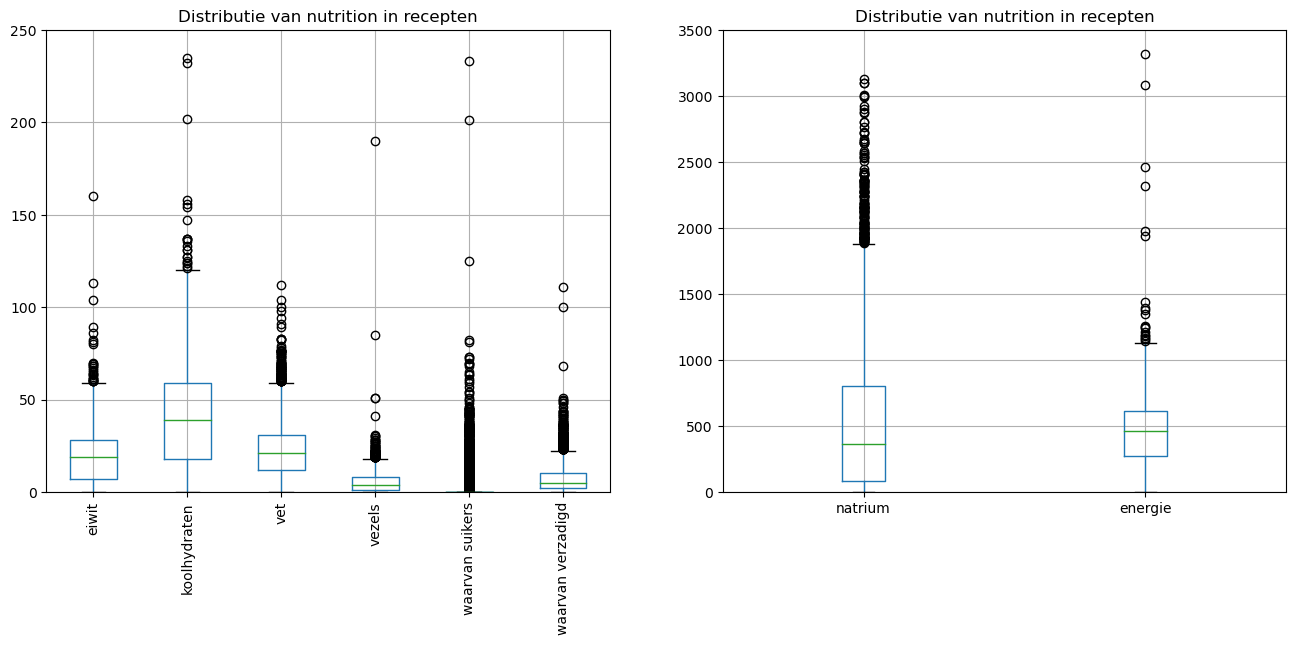

In [2]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

nutritions1 = nut_pivot[['eiwit', 'koolhydraten', 'vet', 'vezels', 'waarvan suikers', 'waarvan verzadigd']]
nutritions1.boxplot(ax=axs[0])
axs[0].set_ylim(0, 250)
axs[0].set_title('Distributie van nutrition in recepten')
axs[0].tick_params(axis='x', labelrotation=90)  # rotate x-axis labels

nutritions2 = nut_pivot[['natrium', 'energie']]
nutritions2.boxplot(ax=axs[1])
axs[1].set_ylim(0, 3500)
axs[1].set_title('Distributie van nutrition in recepten')

plt.show()

# Verschillende keukens

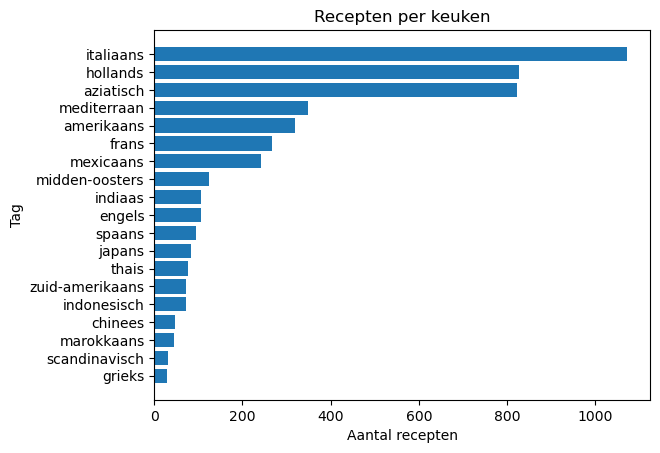

In [5]:
tags_to_count = ['amerikaans','aziatisch','chinees','engels','frans','grieks','hollands','indiaas','indonesisch','italiaans', 'japans','marokkaans','mediterraan', 'mexicaans', 'midden-oosters','scandinavisch','spaans','thais','zuid-amerikaans']
tag_counts = pd.Series([nut_pivot['tags'].str.contains(tag).sum() for tag in tags_to_count], index=tags_to_count)

tag_counts = tag_counts.sort_values(ascending=True)

plt.barh(tag_counts.index, tag_counts.values)
plt.title('Recepten per keuken')
plt.ylabel('Tag')
plt.xlabel('Aantal recepten')
plt.show()


# 2. Predictive Analysis

In [53]:
# oude methode 17-2-23   
# def is_gezond(recept):
#    return (recept['energie'] < 500 and 
#            recept['waarvan suikers'] < 10 and 
#            recept['waarvan verzadigd'] < 10) or \
#           (recept['eiwit'] >= 10 and 
#            recept['vezels'] >= 3 and 
#            recept['natrium'] < 500) or \
#           (recept['koolhydraten'] < 50 and 
#            recept['vet'] < 4)

# oude methode 22-2-23 
# recepten = recepten.assign(voorspelling_gezonde_score_rfr=rf.predict(recepten[features]).round(0))
# recepten = recepten.assign(voorspelling_gezonde_score_lr=lr.predict(recepten[features]).round(0))
# recepten = recepten.assign(voorspelling_gezonde_score_ridge=ridge.predict(recepten[features]).round(0))


recepten = nut_pivot
# hier defineer ik wanneer een recept gezond is. Dit is mijn eigen verzonnen formule. 
def get_gezonde_score(recept):
    score = 1
    
    # Energie criteria
    if recept['energie'] < 500 and recept['waarvan suikers'] < 10 and recept['waarvan verzadigd'] < 25:
        score += 2
    if recept['energie'] < 750 and recept['koolhydraten'] < 65 and recept['vezels'] >= 5:
        score += 1
    if recept['energie'] < 1000 and recept['eiwit'] > 15 and recept['vezels'] >= 10:
        score += 1
    
    # Eiwit criteria
    if recept['eiwit'] >= 10 and recept['waarvan suikers'] < 30 and recept['vet'] < 40:
        score += 2
    if recept['eiwit'] >= 10 and recept['koolhydraten'] < 75 and recept['vezels'] >= 5:
        score += 1
    if recept['eiwit'] >= 10 and recept['vezels'] >= 5 and recept['natrium'] < 1500:
        score += 1
    
    # Koolhydraten criteria
    if recept['koolhydraten'] < 50 and recept['vet'] < 15:
        score += 1
        
    return score

recepten['gezonde_score'] = recepten.apply(get_gezonde_score, axis=1)

X = recepten[['eiwit', 'vet', 'koolhydraten', 'energie', 'natrium', 'vezels', 'waarvan suikers', 'waarvan verzadigd']]
y = recepten[['gezonde_score']]

# de data splits ik hier op
X_main, X_test, y_main, y_test, recipe_main, recipe_test = train_test_split(X, y, recepten['recipe'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val, recipe_train, recipe_val = train_test_split(X_main, y_main, recipe_main, test_size = 0.25, random_state=42)

# Train en test Random Forest Regressor
rfr = RandomForestRegressor(random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
rfr.fit(X_train, y_train)
rfr_pred = rfr.predict(X_test)
rfr_mse = mean_squared_error(y_test, rfr_pred)

# Train en test Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)

# Train en test Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)

print('Random Forest Regressor MSE:', rfr_mse)
print('Linear Regression MSE:', lr_mse)
print('Ridge Regression MSE:', ridge_mse)

result = []
result.append(y_test.to_numpy().flatten())
result.append(rfr.predict(X_test))
result.append(lr.predict(X_test).flatten())
result.append(ridge.predict(X_test).flatten())
result.append(recipe_test.to_numpy())

DataFramenames = ['gezonde_score', 'RandomForestRegressor', 'linearRegression', 'Ridge', 'recipe']
resultframe = pd.DataFrame(result).transpose()
resultframe.columns = DataFramenames
resultframe = resultframe.merge(tags_together[['recipe', 'tags']], on='recipe', how='left')
resultframe


/tmp/ipykernel_39549/2648431718.py:56: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfr.fit(X_train, y_train)


Random Forest Regressor MSE: 0.017399727168294084
Linear Regression MSE: 2.8822501662387494
Ridge Regression MSE: 2.882250222253903


,gezonde_score,RandomForestRegressor,linearRegression,Ridge,recipe,tags
0,7,7.0,5.529194,5.529189,Hertenbief met paddenstoelen en pastinaakpuree,"hoofdgerecht,halloween,sinterklaas,sinterklaas..."
1,5,5.01,4.582594,4.582592,Gehakt-tomatensaus met zilvervliesrijst en spe...,"gezond,glutenvrij,lactosevrij,budget,rijst,hoo..."
2,2,2.48,2.575108,2.575112,Pittige ovenaardappelen met dips,"vegetarisch,oven,mexicaans,bijgerecht,kerst,ou..."
3,4,4.0,5.059704,5.059705,Courgette bruschetta koolhydraatarm,"glutenvrij,lactosevrij,zonder vlees,borrelhapj..."
4,5,5.0,5.933451,5.933447,Ossenhaas wellington,"engels,hoofdgerecht,koken,slank,engels,hoofdge..."
...,...,...,...,...,...,...
1736,4,4.0,4.436797,4.436795,"Lentequiche met asperges, broccoli en garnalen","vooraf te maken,oven,frans,quiche,hoofdgerecht..."
1737,3,3.0,4.093688,4.093689,Rachel Khoo's tarte tatin met wortel,"vegetarisch,oven,frans,quiche,voorgerecht,vege..."
1738,6,6.0,5.16767,5.16767,Garnalencocktail met hangop en bieslook,"salade,voorgerecht,kerst,salade,voorgerecht,ke..."
1739,4,4.0,4.413826,4.413828,Ross Dobson's gegrilde venkel met kruidendressing,"glutenvrij,vegetarisch,lactosevrij,vooraf te m..."


In [52]:
#tuning hyperparameters RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6]
}

rfr = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_test, y_test)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best MSE: {-grid_search.best_score_}")

/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/jupyterhub/anaconda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: Dat

Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Best MSE: 0.06473881883377794


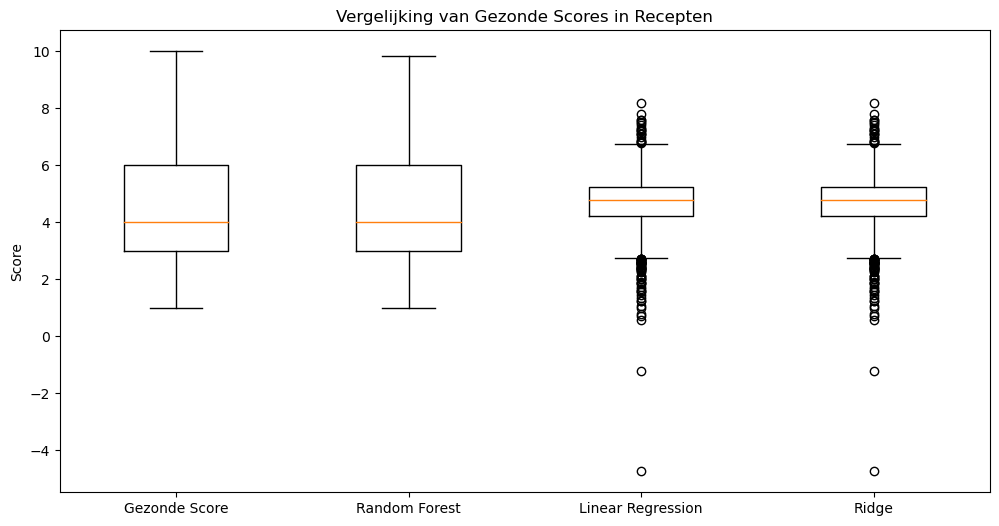

In [4]:
data = [resultframe['gezonde_score'], resultframe['RandomForestRegressor'], 
        resultframe['linearRegression'], resultframe['Ridge']]

fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(data)
ax.set_xticklabels(['Gezonde Score', 'Random Forest', 
                    'Linear Regression', 'Ridge'])
ax.set_ylabel('Score')
ax.set_title('Vergelijking van Gezonde Scores in Recepten')
plt.show()

#                                  Model keuze = RandomForest
Uit de resultaten van de drie modellen blijkt dat de MSE van het RandomForestRegressor-model lager is dan de MSE van het Lineaire regressiemodel en van de Ridge. Dit betekent dat het RandomForestRegressor-model beter presteert in het voorspellen van de gezonde score van de recepten dan het Lineaire regressiemodel en de Ridge. Het LinearRegression en Ridge zijn bijna hetzelfde, dit klopt omdat Ridge regession een extensie is van LinearRegression. Daarom is het logisch om verder te gaan met het RandomForestRegressor-model in plaats van het Lineaire regressiemodel of Ridge.


# Visualisaties met voorspelling RandomForestRegressor

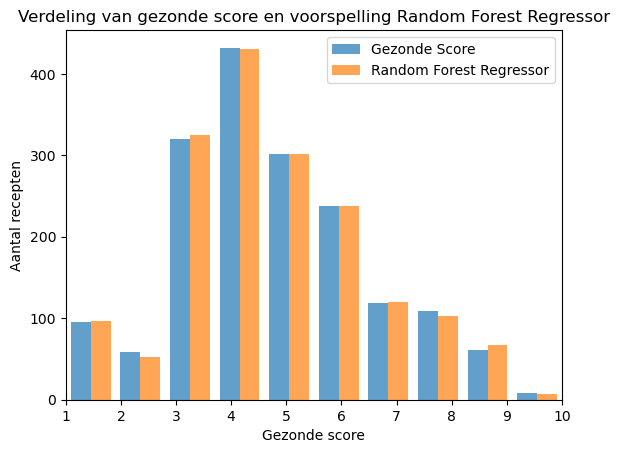

In [42]:
plt.hist([resultframe['gezonde_score'], resultframe['RandomForestRegressor']], bins=10, label=['Gezonde Score', 'Random Forest Regressor'], alpha=0.7)
plt.title('Verdeling van gezonde score en voorspelling Random Forest Regressor')
plt.xlabel('Gezonde score')
plt.ylabel('Aantal recepten')
plt.legend(loc='upper right')
plt.xlim(1, 10)
plt.show()

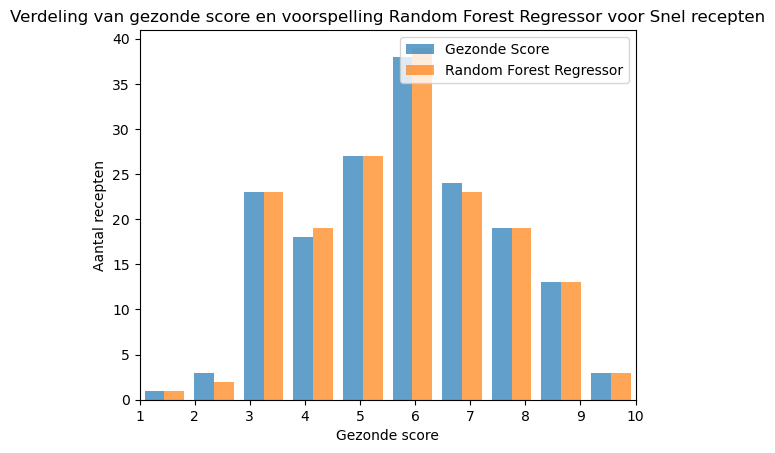

In [45]:
snel_mask = resultframe['tags'].str.contains('snel')
snel_resultframe = resultframe[snel_mask]

plt.hist([snel_resultframe['gezonde_score'], snel_resultframe['RandomForestRegressor']], bins=10, label=['Gezonde Score', 'Random Forest Regressor'], alpha=0.7)
plt.title('Verdeling van gezonde score en voorspelling Random Forest Regressor voor Snel recepten')
plt.xlabel('Gezonde score')
plt.ylabel('Aantal recepten')
plt.legend(loc='upper right')
plt.xlim(1, 10)
plt.show()


# algemeen denken mensen dat snelle recepten ongezond is. Maar dat valt toch wel tegen.

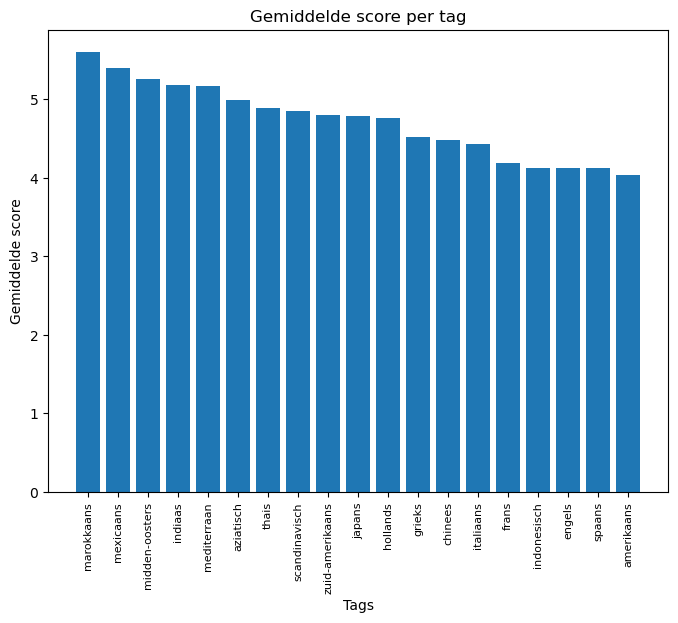

In [55]:
mean_scores = []
for tag in tags_to_count:
    mean_score = recepten[recepten['tags'].str.contains(tag)]['gezonde_score'].mean()
    mean_scores.append(mean_score)

tags_to_count, mean_scores = zip(*sorted(zip(tags_to_count, mean_scores), key=lambda x: x[1], reverse=True))


fig, ax = plt.subplots(figsize=(8,6))
ax.bar(tags_to_count, mean_scores)
ax.set_xlabel('Tags')
ax.set_ylabel('Gemiddelde score')
ax.set_title('Gemiddelde score per tag')
plt.xticks(rotation=90, fontsize=8)
plt.show()